### Read in data

In [1]:
library(edgeR)
library(reshape2)
library(tidyr)
library(dplyr)
library(ggplot2)
library(EnhancedVolcano)
library(stringr)
library(countdata)

Loading required package: limma


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggrepel



In [2]:
raw_counts = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_all.tsv"
info = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_with_info.tsv"

# read in tabel with raw counts
raw_counts = read.table(raw_counts, header = TRUE, sep = "\t")
# read in table with info
info = read.table(info, header = TRUE, sep = "\t")
# merge the two tables on the column "Synt_id"
raw_counts = merge(raw_counts, info, by = "Synt_id")
# set synt_id as rownames
rownames(raw_counts) = raw_counts$Synt_id
# remove the column "Synt_id"
raw_counts = raw_counts[,-1]
# replaace NA values with 0
raw_counts[is.na(raw_counts)] = 0
# filter the genes that have length_category == more_20%_difference and mulitmapping_tag = mulitmapping 
#raw_counts_filter = raw_counts[raw_counts$haplotype_with_longest_annotation == "equal_lengths" & raw_counts$multimapping_tag != "multimapping",]
#raw_counts_filter = raw_counts[raw_counts$length_category != "more_20%_difference" & raw_counts$multimapping_tag != "multimapping",]
raw_counts_filter = raw_counts[raw_counts$multimapping_tag != "multimapping",]
# get the sample columns starting with SRR
sample_columns = colnames(raw_counts_filter)[grep("SRR", colnames(raw_counts_filter))]
# only keeep the columns with the sample names
raw_counts_filter = raw_counts_filter[, sample_columns]
raw_counts = raw_counts[, sample_columns]
# Filter the counts to make sure that for each tissue they have at least 20 counts
leaf_samples = colnames(raw_counts_filter)[grep("leaf", colnames(raw_counts_filter))]
tuber_samples = colnames(raw_counts_filter)[grep("tuber", colnames(raw_counts_filter))]
raw_counts_filter = raw_counts_filter[rowSums(raw_counts_filter[,leaf_samples]) > 100 & rowSums(raw_counts_filter[,tuber_samples]) > 100,]
# select rows with at least 80 counts in totatl
#raw_counts_filter = raw_counts_filter[rowSums(raw_counts_filter) > 80,]
dim(raw_counts_filter)
# raw counts for synt 261
raw_counts_filter["261",]


[1] 1160   40

SRR14993892_leaf_1 SRR14993892_leaf_2 SRR14993892_leaf_3 SRR14993892_leaf_4
261 0                  0                  0                  14                
    SRR14993893_leaf_1 SRR14993893_leaf_2 SRR14993893_leaf_3 SRR14993893_leaf_4
261 0                  0                  0                  2                 
    SRR14993894_leaf_1 SRR14993894_leaf_2 ⋯ SRR14995034_tuber_3
261 0                  0                  ⋯ 0                  
    SRR14995034_tuber_4 SRR14995933_tuber_1 SRR14995933_tuber_2
261 13                  46                  0                  
    SRR14995933_tuber_3 SRR14995933_tuber_4 SRR14996168_leaf_1
261 0                   19                  0                 
    SRR14996168_leaf_2 SRR14996168_leaf_3 SRR14996168_leaf_4
261 0                  0                  57

### Compare Unfiltered and filtered data

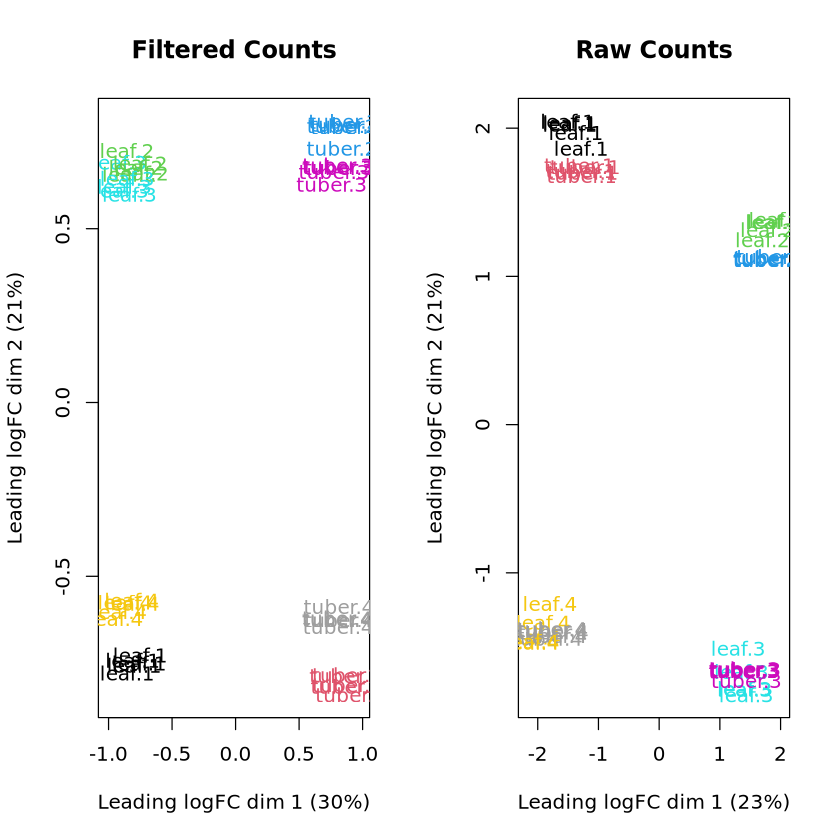

In [3]:
# Set up plotting layout: 1 row and 2 columns
par(mfrow = c(1, 2))

# Loop through raw_counts_filter and raw_counts
for (counts in list(raw_counts_filter, raw_counts)) {
    # Create DGEList and calculate normalization factors
    d0 <- DGEList(counts)
    d0 <- calcNormFactors(d0)
    
    # Filter genes based on CPM values
    cutoff <- 1
    min_samples <- 2  # Minimum number of samples where the gene must exceed the cutoff
    cpm_values <- cpm(d0)
    keep <- rowSums(cpm_values >= cutoff) >= min_samples
    d <- d0[keep, ]
    dim(d)
    
    # Extract group information
    snames <- colnames(counts)
    split_parts <- strsplit(snames, "_")
    tissue <- sapply(split_parts, `[`, 2)
    allele <- sapply(split_parts, `[`, 3)
    group <- interaction(tissue, allele)
    
    # Plot MDS
    plotMDS(d, col = as.numeric(group), labels = group, main = ifelse(identical(counts, raw_counts_filter), "Filtered Counts", "Raw Counts"))
}


### Filtered data

Is the allelic ratio between tuber and leave different for one allele?

In [4]:
# Define the list of allele suffixes
allele_suffixes <- c("_1", "_2", "_3", "_4")

# Create a copy of raw_counts_filter for modifications
raw_counts_filter_bionom <- raw_counts_filter

raw_counts_filter_bionom$Synt_id <- rownames(raw_counts_filter_bionom)
# Assume `raw_counts_filter_bionom` has the processed data with columns: Synt_id, base_variable, allele counts
# Convert the data to long format
melted_table <- raw_counts_filter_bionom %>%
  pivot_longer(
    cols = starts_with("SRR"), # Adjust column name pattern if needed
    names_to = "variable",
    values_to = "value"
  )

# Extract allele information (_1, _2, _3, _4) from the variable names
melted_table <- melted_table %>%
  mutate(
    allele = case_when(
      str_detect(variable, "_1$") ~ "allele_1",
      str_detect(variable, "_2$") ~ "allele_2",
      str_detect(variable, "_3$") ~ "allele_3",
      str_detect(variable, "_4$") ~ "allele_4",
      TRUE ~ NA_character_
    )
  )

# Remove rows where allele is NA (if any)
melted_table <- melted_table %>%
  filter(!is.na(allele))

# Replace `_1`, `_2`, `_3`, `_4` suffixes in the 'variable' column to create 'base_variable'
melted_table <- melted_table %>%
  mutate(base_variable = str_remove(variable, "_[1234]$"))

melted_table$tissue = str_split_fixed(melted_table$base_variable, "_", 3)[,2]


# Pivot the table to have alleles as columns and genes + samples as rows
pivoted_table <- melted_table %>%
  pivot_wider(
    id_cols = c(Synt_id, base_variable), # Rows: gene (Synt_id) and sample (base_variable)
    names_from = allele,                # Columns: alleles
    values_from = value                 # Values: counts
  )


# add a column with the sum of the counts for each gene
pivoted_table$sum_counts = rowSums(pivoted_table[,grep("allele", colnames(pivoted_table))])
pivoted_table$tissue = str_split_fixed(pivoted_table$base_variable, "_", 3)[,2]
# Display the pivoted table
print(pivoted_table)

# A tibble: 11,600 × 8
   Synt_id base_variable   allele_1 allele_2 allele_3 allele_4 sum_counts tissue
   <chr>   <chr>              <dbl>    <dbl>    <dbl>    <dbl>      <dbl> <chr> 
 1 44      SRR14993892_le…        4       12       11        6         33 leaf  
 2 44      SRR14993893_le…        5        4        2        7         18 leaf  
 3 44      SRR14993894_le…       45       57       40       76        218 leaf  
 4 44      SRR14993895_le…       18       17        6       15         56 leaf  
 5 44      SRR14995031_tu…        9       32        9       12         62 tuber 
 6 44      SRR14995032_tu…        8        6        4        3         21 tuber 
 7 44      SRR14995033_tu…        8        7        7       11         33 tuber 
 8 44      SRR14995034_tu…        7        5        1        6         19 tuber 
 9 44      SRR14995933_tu…       11       12        6        2         31 tuber 
10 44      SRR14996168_le…       27       37       17       45        126 leaf  
# ℹ 1

### Beta-Bionomial test

Sum the count within each sample

#### Pivot table

In [ ]:
results_df[results_df$Synt_id == "1885",]
# plot info for synt id 9918
info %>% filter(Synt_id == "1885")

Synt_id p_value      mean_group1 mean_group2 fold_change p_adj       
478 1885    1.108308e-06 0.867052    0.1650485   5.253315    9.420617e-05
    significant
478 red

Synt_id X1  X2 X3 X4 num_reads_multi multi_ratio allele_ratio_hap1
1 1885    167 5  99 5  7               0.02473498  0.6050725        
  allele_ratio_hap2 allele_ratio_hap3 allele_ratio_hap4 multimapping_tag
1 0.01811594        0.3586957         0.01811594        unique          
  ref_length_1G ref_length_2G ref_length_3G ref_length_4G
1 5406          3991          5196          5077         
  haplotype_id                                                                                                                                                                                                                                                                                    
1 Synt_4469_chr02_1G_x4|hap1_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_1G007980Synt_4469_chr02_2G_x4|hap2_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_2G009370Synt_4469_chr02_3G_x4|hap3_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_3G009230Synt_4469_chr02_4G_x4|hap4_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_4G008890
  length_category     haplotype_with_longest_annotation
1 more_20%_difference 1G

In [ ]:
results_df[results_df$Synt_id == "4228",]
# plot info for synt id 9918
info %>% filter(Synt_id == "4228")

Synt_id p_value     mean_group1 mean_group2 log_fold_change p_adj      
164 4228    2.78377e-08 0.3022071   0.4741907   -0.6499297      2.29661e-06

Synt_id X1   X2   X3   X4   num_reads_multi multi_ratio allele_ratio_hap1
1 4228    2330 1407 1671 1001 104             0.01622718  0.3635513        
  allele_ratio_hap2 allele_ratio_hap3 allele_ratio_hap4 multimapping_tag
1 0.219535          0.2607271         0.1561866         unique          
  ref_length_1G ref_length_2G ref_length_3G ref_length_4G
1 825           826           827           823          
  haplotype_id                                                                                                                                                                                                                                                                                    
1 Synt_8548_chr03_1G_x4|hap1_Soltu.DM.03G026780.1|Soltu.Atl_v3.03_1G022940Synt_8548_chr03_2G_x4|hap2_Soltu.DM.03G026780.1|Soltu.Atl_v3.03_2G020440Synt_8548_chr03_3G_x4|hap3_Soltu.DM.03G026780.1|Soltu.Atl_v3.03_3G028400Synt_8548_chr03_4G_x4|hap4_Soltu.DM.03G026780.1|Soltu.Atl_v3.03_4G019160
  length_category    haplotype_with_longest_annotation
1 less_1%_difference 3G

Allele 2

In [6]:
# Define the alleles to test
alleles <- paste0("allele_", 1:4)

# make a test table 
#pivoted_table_test = pivoted_table[1:10,]

# test for synt id 261
#pivoted_table_test = pivoted_table[pivoted_table$Synt_id == "261",]

# Split the data by unique Synt_id values
split_data <- split(pivoted_table, pivoted_table$Synt_id)

# Use lapply to perform the operation on each subset and collect results
results_list <- lapply(names(split_data), function(synt_id) {
  test_data <- split_data[[synt_id]]
  
  # Drop the rows where sum_counts is 0
  test_data <- test_data[test_data$sum_counts != 0, ]
  
  # Initialize a list to store results for each allele
  allele_results <- lapply(alleles, function(allele) {
    # Drop the rows where the allele count is 0
    test_data_allele <- test_data # [test_data[[allele]] != 0, ]
    print(test_data_allele)
    # Check if there's enough data to perform the test
    if (length(unique(test_data_allele$tissue)) < 2) {
      return(data.frame(
        Synt_id = synt_id,
        allele = allele,
        p_value = NA,
        mean_group1 = NA,
        mean_group2 = NA,
        fold_change = NA
      ))
    }
    
    # Perform the Binomial test
    test_result <- bb.test(
      x = test_data_allele[[allele]],
      tx = test_data_allele$sum_counts,
      group = test_data_allele$tissue,
      n.threads = 10
    )
    
    # Calculate the means for the two groups
    group_means <- aggregate(
      cbind(allele_counts = test_data_allele[[allele]], sum_counts = test_data_allele$sum_counts),
      by = list(tissue = test_data_allele$tissue),
      FUN = sum
    )
    group_means$mean <- group_means$allele_counts / group_means$sum_counts
    print(group_means$mean)
    # Ensure there are exactly two groups
    if (nrow(group_means) != 2) {
      return(data.frame(
        Synt_id = synt_id,
        allele = allele,
        p_value = NA,
        mean_group1 = NA,
        mean_group2 = NA,
        fold_change = NA
      ))
    }
    
    # Calculate fold change
    fold_change <- group_means$mean[1] / group_means$mean[2]
    
    # Create a data frame with the results
    data.frame(
      Synt_id = synt_id,
      allele = allele,
      p_value = test_result$p.value,
      mean_group1 = group_means$mean[1],
      mean_group2 = group_means$mean[2],
      fold_change = fold_change
    )
  })
  
  # Combine the allele results
  do.call(rbind, allele_results)
})

# Combine the list of data frames into a single data frame
results_df <- do.call(rbind, results_list)


# A tibble: 10 × 8
   Synt_id base_variable   allele_1 allele_2 allele_3 allele_4 sum_counts tissue
   <chr>   <chr>              <dbl>    <dbl>    <dbl>    <dbl>      <dbl> <chr> 
 1 10015   SRR14993892_le…       16       29       23       33        101 leaf  
 2 10015   SRR14993893_le…       10        8       13       20         51 leaf  
 3 10015   SRR14993894_le…       68      145      103      136        452 leaf  
 4 10015   SRR14993895_le…       33       75       59       70        237 leaf  
 5 10015   SRR14995031_tu…        7       11        8       10         36 tuber 
 6 10015   SRR14995032_tu…        4        9       12       17         42 tuber 
 7 10015   SRR14995033_tu…        5        7        4        8         24 tuber 
 8 10015   SRR14995034_tu…        7        5        2        5         19 tuber 
 9 10015   SRR14995933_tu…        6        6        3        2         17 tuber 
10 10015   SRR14996168_le…       58      127       59       87        331 leaf  
Using a s

In [7]:
# print the results from synt id 261
results_df[results_df$Synt_id == "261",]

Synt_id allele   p_value      mean_group1 mean_group2 fold_change
1657 261     allele_1 1.148449e-08 0           0.7639594   0.000000   
1658 261     allele_2 1.000000e+00 0           0.0000000        NaN   
1659 261     allele_3 1.000000e+00 0           0.0000000        NaN   
1660 261     allele_4          NaN 1           0.2360406   4.236559

[1] "allele_1" "allele_2" "allele_3" "allele_4"

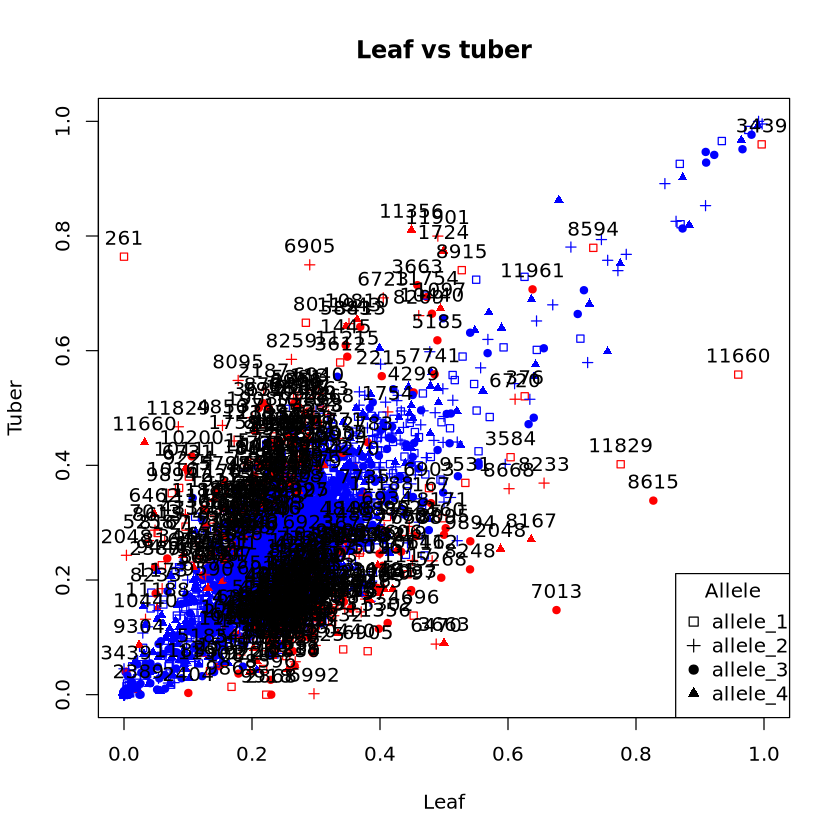

In [9]:
# Define point shapes for each category
# You can choose pch values between 0 and 25 for different shapes
pch_values <- c(0, 3, 19, 17)  # Shapes for categories A, B, C

# Map the factor levels to pch values
results_df$allele = factor(results_df$allele)
levels(results_df$allele)  # Should be "A", "B", "C"
pch_map <- setNames(pch_values, levels(results_df$allele))

# Create a vector of pch values for each row
point_shapes <- pch_map[results_df$allele]

# add a column for significant genes werhe p_adj < 0.005
results_df$p_adj <- p.adjust(results_df$p_value, method="fdr")
results_df$significant = ifelse(results_df$p_adj < 0.005, "red", "blue")
plot(results_df$mean_group1, results_df$mean_group2, xlab = "Leaf", ylab = "Tuber", main = "Leaf vs tuber",  col = results_df$significant, pch = point_shapes, cex = 0.8, xlim = c(0, 1), ylim = c(0, 1))
legend("bottomright", legend = levels(results_df$allele), pch = pch_values, col = "black", title = "Allele")

# label the points that are red
text(results_df$mean_group1[results_df$significant == "red"], results_df$mean_group2[results_df$significant == "red"] , labels = results_df$Synt_id[results_df$significant == "red"], pos = 3)


In [16]:
# count the number of significant genes
# filter the results_df for significant genes
results_df_significant = results_df[results_df$p_adj < 0.05,]
# group the results by synt id
results_df_significant_grouped = results_df_significant %>% group_by(Synt_id) %>% summarise(n = n())
nrow(results_df_significant_grouped)

[1] 563

## Testing

In [ ]:
mm <- model.matrix(~0 + group)
y <- voom(d, mm, plot = T)
fit <- lmFit(y, mm)
contr <- makeContrasts(contrasts ="groupleaf.1 -  groupleaf.2" , levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, coef = 2) # Directly test second coefficient
tmp <- eBayes(tmp)
top.table <- topTable(tmp, sort.by = "P", n = Inf)
d0 <- DGEList(raw_counts_filter)
d0 <- calcNormFactors(d0)
cutoff <- 5
min_samples <- 2  # Minimum number of samples where the gene must exceed the cutoff
cpm_values <- cpm(d0)
keep <- rowSums(cpm_values >= cutoff) >= min_samples
d <- d0[keep, ]
dim(d)
snames <- colnames(raw_counts) 
# Split the strings
split_parts <- strsplit(snames, "_")

# Extract the second element from each split
tissue <- sapply(split_parts, `[`, 2)
allele <- sapply(split_parts, `[`, 3)
group <- interaction(tissue, allele)
plotMDS(d, col = as.numeric(group), labels = group)


ERROR: Error in lmFit(y, design, block = block, correlation = correlation, weights = weights): row dimension of design doesn't match column dimension of data object
